## Análise de Resultados

In [6]:
import sys, os
import plotly.graph_objects as go
import numpy as np

sys.path.insert(0, "/media/workspace/DeepFood/deep-reco-gym/tools/eval_viz")
import pandas as pd
import argparse
import copy
import numpy as np
import os
import random
import json
from pandas.io.json import json_normalize
from app import fetch_iteraction_results_path, load_all_iteraction_metrics
from app import load_iteractions_params as load_iteractions_params2, PATH_EVAL_REINFORCEMENT
from plot import plot_line_iteraction, plot_exploration_arm, get_colors, confidence
import pandas as pd
import argparse
import copy
import numpy as np
import streamlit as st
import seaborn as sns
sns.set(style="darkgrid")
#sys.path.insert(0, os.path.dirname(__file__))
import matplotlib.pyplot as plt
from app import load_data_metrics, load_eval_params, filter_df, fetch_results_path


In [7]:
# models_and_legend = {
#   "____random_":           ["bandit_policy", "observation"],
#   "____fixed_":            ["bandit_policy", "observation"],
#   "____lin_ucb_":          ["bandit_policy", "bandit_policy_params.alpha", "full_refit", "val_split_type"],
#   "____model_":            ["bandit_policy","full_refit", "val_split_type"],
#   "____custom_lin_ucb_":   ["bandit_policy", "bandit_policy_params.alpha", "full_refit", "val_split_type"],
#   "____epsilon_greedy_":   ["bandit_policy","bandit_policy_params.epsilon", "full_refit", "val_split_type"],
#   "____softmax_":          ["bandit_policy","bandit_policy_params.logit_multiplier", "full_refit", "val_split_type"],
#   "____lin_ts_":           ["bandit_policy","bandit_policy_params.v_sq", "full_refit", "val_split_type"],
#   "____percentile_adapt_":       ["bandit_policy","bandit_policy_params.exploration_threshold", "full_refit", "val_split_type"],
#   "____adaptive_":         ["bandit_policy","bandit_policy_params.exploration_threshold", "bandit_policy_params.decay_rate", "full_refit", "val_split_type"],  
#   "____explore_then_exp_": ["bandit_policy","bandit_policy_params.explore_rounds", "bandit_policy_params.decay_rate", "full_refit", "val_split_type"],    
# }

models_and_legend = {
  "____remote_":           ["bandit_policy", "obs"],
}
path = PATH_EVAL_REINFORCEMENT

In [8]:
models_and_legend

{'____remote_': ['bandit_policy', 'obs']}

In [9]:
def list_paths_per_model(input_path):
    models = []
    
    for model, legend in models_and_legend.items():
    #print(model)
    #print(legend)
        for root, dirs, files in os.walk(input_path):
            if '/results' in root and 'Interaction' in root:
                for d in dirs:
                    #print(os.path.join(root, d))
                    if model in d:
                        models.append(os.path.join(root, d))
    return models

def load_iteractions_params(iteractions):
  if len(iteractions) == 0:
    return pd.DataFrame()

  dfs = []

  for model in iteractions:

    file_path = os.path.join(model, 'params.json')
    data      = []

    #try:
    with open(file_path) as json_file:
        d = json.load(json_file)
        data.append(d)

        df = pd.DataFrame.from_dict(json_normalize(data), orient='columns')
      
    #except:
    #  df = pd.DataFrame()

    df['iteraction'] = model
    dfs.append(df)
  
  return pd.concat(dfs)


def load_data_iteractions_metrics(path, sample_size = 10000):
    random.seed(42)
    file      = os.path.join(path,'sim-datalog.csv')

    # Count the lines
    num_lines = sum(1 for l in open(file)) - 1

    # Sample size - in this case ~10%
    size = np.min([sample_size, num_lines])#int(num_lines / 10)

    # The row indices to skip - make sure 0 is not included to keep the header!
    skip_idx  = sorted(random.sample(range(1, num_lines), num_lines - size))
    idx       = list(set(list(range(num_lines))) - set(skip_idx))

    df        = pd.read_csv(file, skiprows=skip_idx)
    
    df        = pd.read_csv(file)#.reset_index()
    idx       = list(range(len(df)))

    df['idx'] = sorted(idx)
    df        = df.sort_values("idx")
    return df


def get_metrics_reward(bandits):
    data    = []
    for i, p in enumerate(bandits):
        df_metrics = load_data_iteractions_metrics(p)
        r_mean     = df_metrics.reward.mean()
        r_reward   = df_metrics.reward.sum()
        data.append((i, r_mean, r_reward))
    df_metrics = pd.DataFrame(data, columns=['idx', 'r_mean', 'r_reward']).set_index('idx')    
    return df_metrics

def group_metrics(df):
    df_g_metrics = df.groupby('bandit').agg({'r_mean': ['mean', 'std'], 'r_reward': ['mean', 'std', 'count'], 'model': 'first' })
    df_g_metrics.columns = df_g_metrics.columns.map(lambda x: '|'.join([str(i) for i in x]))
    return df_g_metrics    
    
result_paths = list_paths_per_model(path)
result_paths

['output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______f99330d50d',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______082858ed2f',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______2a51a4f76e',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______5ef0d3d7a0',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______4658c1f6cc',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______ae87ca9ccb',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______d7ec2bac42',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_epsilon_g___endpoints______af7c690687',
 'output/interacti

In [10]:
fetch_results_path()

{'TrivagoLogisticModelInteraction_selu____softmax_explorer_ecf6ca42ee_89372c6587_ps_per_logistic_regression_of_pos_item_idx_and_item_ps': 'output/evaluation/EvaluateTrivagoTestSetPredictions/results/TrivagoLogisticModelInteraction_selu____softmax_explorer_ecf6ca42ee_89372c6587_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'}

## Filter Data

In [11]:
result_paths

['output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______f99330d50d',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______082858ed2f',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______2a51a4f76e',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______5ef0d3d7a0',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______4658c1f6cc',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______ae87ca9ccb',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______d7ec2bac42',
 'output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_epsilon_g___endpoints______af7c690687',
 'output/interacti

In [12]:
df_params = load_iteractions_params(result_paths)
df_params.head()

/home/marlesson/anaconda3/envs/deep-reco-gym/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,balance_fields,bandit_policy,bandit_policy_params.c,bandit_policy_params.endpoints,bandit_policy_params.epsilon,bandit_policy_params.logit_multiplier,bandit_policy_params.window_reward,batch_size,dataset_split_method,device,...,seed,session_test_size,split_index,test_size,test_split_type,use_sampling_in_validation,user_column,user_idx_column,val_size,val_split_type
0,[],remote_ucb,5.0,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,NaN,5000.0,500,time,cuda,...,42,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_contextual_epsilon_greedy,NaN,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",0.20,NaN,NaN,500,time,cuda,...,9,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_contextual_epsilon_greedy,NaN,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",0.05,NaN,NaN,500,time,cuda,...,8,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_contextual_epsilon_greedy,NaN,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",0.05,NaN,NaN,500,time,cuda,...,5,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_contextual_softmax,NaN,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,100.0,NaN,500,time,cuda,...,3,0.1,0,0.0,time,False,account_id,account_idx,0.0,time


In [13]:
df_params.obs.unique()

array(['[MAB]UCB(5000-5)', '[Contextual]e-greedy(20) 9',
       '[Contextual]e-greedy(5) 8', '[Contextual]e-greedy(5) 5',
       '[Contextual]Softmax(100) 3', '[MAB] UCB  5', '[MAB] UCB  6',
       '[MAB] e-greedy 2', '[Contextual] Softmax 6',
       '[Contextual]e-greedy(5) 10', '[MAB] UCB  2', '[MAB] e-greedy 5',
       '[Contextual]Softmax(10) 5', '[Contextual]e-greedy(5) 7',
       '[Contextual]e-greedy(10) 1', '[Contextual]Softmax(100) 4',
       'MostPopularPerUser', '[Contextual]Softmax(100) 6',
       '[MAB]UCB(1000-20)', '[Contextual]Softmax(10) 6',
       '[Contextual]Softmax(10) 9', '[Contextual]Softmax(50) 8',
       '[Contextual]e-greedy(20) 1', '[MAB]UCB(5000-50)',
       '[Contextual]e-greedy(10) 2', '[Contextual]Softmax(50) 5',
       '[Contextual] Softmax 3', '[Contextual]e-greedy(10) 5',
       '[MAB]UCB(1000-50)', '[Contextual]e-greedy(20) 7',
       '[Contextual] e-greedy 1', '[MAB]UCB(500-5)',
       '[Contextual]Softmax(50) 1', '[Contextual]Softmax(500) 6',
      

In [14]:
df_params['obs'].apply(lambda x: " ".join(x.split(" ")[:-1]).strip()).unique()

array(['', '[Contextual]e-greedy(20)', '[Contextual]e-greedy(5)',
       '[Contextual]Softmax(100)', '[MAB] UCB', '[MAB] e-greedy',
       '[Contextual] Softmax', '[Contextual]Softmax(10)',
       '[Contextual]e-greedy(10)', '[Contextual]Softmax(50)',
       '[Contextual] e-greedy', '[Contextual]Softmax(500)', '[MAB]'],
      dtype=object)

In [15]:
df_params
#df_params['observation'] = df_params['obs'].apply(lambda x: " ".join(x.split(" ")[:-2]))
df_params['observation'] = df_params['obs'].apply(lambda x: " ".join(x.split(" ")[:-1]) if len(x.split(" ")) > 1 else x)
#df_params['observation'] = df_params['observation']+df_params['logit_multiplier']

df_params['observation'].unique()

array(['[MAB]UCB(5000-5)', '[Contextual]e-greedy(20)',
       '[Contextual]e-greedy(5)', '[Contextual]Softmax(100)',
       '[MAB] UCB ', '[MAB] e-greedy', '[Contextual] Softmax',
       '[Contextual]Softmax(10)', '[Contextual]e-greedy(10)',
       'MostPopularPerUser', '[MAB]UCB(1000-20)',
       '[Contextual]Softmax(50)', '[MAB]UCB(5000-50)',
       '[MAB]UCB(1000-50)', '[Contextual] e-greedy', '[MAB]UCB(500-5)',
       '[Contextual]Softmax(500)', '[MAB]UCB(1000-5)', 'CDAE',
       '[MAB]UCB(1000-1)', 'MostPopular', 'MatrixFactorization',
       '[MAB]UCB(500-100)', '[MAB]UCB(500-50)', '[MAB]UCB(1000-100)',
       '[MAB]UCB(500-1)', '[MAB]', '[MAB]UCB(5000-1)', 'CVAE',
       '[MAB]UCB(1000-10)', 'Random', '[MAB]e-greedy(100-0.05)'],
      dtype=object)

In [16]:
list_bandits          = df_params.groupby(["bandit_policy", "observation"])['iteraction'].apply(list).reset_index()
list_bandits['name']  = list_bandits.bandit_policy.map(str) + ' ' + list_bandits.observation.map(str)
list_bandits['name']  = list_bandits['name'].apply(lambda x: x.replace("fixed ", "").replace(" ", ""))
list_bandits['model'] = list_bandits.iteraction.apply(lambda l: l[np.random.randint(0, len(l))])
list_bandits['model_list'] = list_bandits.iteraction
list_bandits

,bandit_policy,observation,iteraction,name,model,model_list
0,remote,CDAE,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6],remoteCDAE,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6]
1,remote,CVAE,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920],remoteCVAE,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920]
2,remote,MatrixFactorization,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d2667d3c0b],remoteMatrixFactorization,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d2667d3c0b,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d2667d3c0b]
3,remote,MostPopular,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______5dab9c3b0a],remoteMostPopular,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______5dab9c3b0a,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______5dab9c3b0a]
4,remote,MostPopularPerUser,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______1c7fdcea43],remoteMostPopularPerUser,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______1c7fdcea43,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______1c7fdcea43]
5,remote,Random,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______44e07863e7],remoteRandom,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______44e07863e7,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______44e07863e7]
6,remote_contextual_epsilon_greedy,[Contextual] e-greedy,"[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______c87eb8d2e4, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______c8e04246ca, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______4e6c98d63b, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______fcb92f2a09, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______08b565350d, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______28dd73806b, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______659dab8004, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______e7f48c2e17, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______7d9bc9b8c0, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______09a2bee226]",remote_contextual_epsilon_greedy[Contextual]e-greedy,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______e7f48c2e17,"[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______c87eb8d2e4, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______c8e0

In [17]:
df_params

,balance_fields,bandit_policy,bandit_policy_params.c,bandit_policy_params.endpoints,bandit_policy_params.epsilon,bandit_policy_params.logit_multiplier,bandit_policy_params.window_reward,batch_size,dataset_split_method,device,...,seed,session_test_size,split_index,test_size,test_split_type,use_sampling_in_validation,user_column,user_idx_column,val_size,val_split_type
0,[],remote_ucb,5.0,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,NaN,5000.0,500,time,cuda,...,42,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_contextual_epsilon_greedy,NaN,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",0.20,NaN,NaN,500,time,cuda,...,9,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_contextual_epsilon_greedy,NaN,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",0.05,NaN,NaN,500,time,cuda,...,8,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_contextual_epsilon_greedy,NaN,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",0.05,NaN,NaN,500,time,cuda,...,5,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_contextual_softmax,NaN,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,100.0,NaN,500,time,cuda,...,3,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,[],remote_contextual_softmax,NaN,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",NaN,500.0,NaN,500,time,cuda,...,2,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_epsilon_greedy,NaN,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",0.05,NaN,100.0,500,time,cuda,...,42,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_contextual_epsilon_greedy,NaN,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",0.10,NaN,NaN,500,time,cuda,...,3,0.1,0,0.0,time,False,account_id,account_idx,0.0,time
0,[],remote_contextual_epsilon_greedy,NaN,"[http://localhost:5001/rank, http://localhost:5003/rank, http://localhost:5004/rank, http://localhost:5005/rank]",0.05,NaN,NaN,500,time,cuda,...,6,0.1,0,0.0,time,False,account_id,account_idx,0.0,time


## Geral

In [18]:
reward_metrics = []
list_bandits.head(2)

,bandit_policy,observation,iteraction,name,model,model_list
0,remote,CDAE,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6],remoteCDAE,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6]
1,remote,CVAE,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920],remoteCVAE,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920]


In [19]:
for i, row in list_bandits.iterrows():
    try:
        df_metrics = get_metrics_reward(row['iteraction'])
        
        df_metrics['bandit'] = str(row['bandit_policy']) + " " + str(row['observation'])
        df_metrics['model']  = row['model']

        df_g_metrics = group_metrics(df_metrics)
        reward_metrics.append(df_g_metrics)
    except FileNotFoundError:
        pass

In [20]:
df_all = pd.concat(reward_metrics)
df_all = df_all.reset_index().sort_values('bandit', ascending=False).set_index('bandit')
df_all

,r_mean|mean,r_mean|std,r_reward|mean,r_reward|std,r_reward|count,model|first
bandit,,,,,,
remote_ucb [MAB]UCB(5000-50),0.101979,NaN,1170.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______1678f503be
remote_ucb [MAB]UCB(5000-5),0.121764,NaN,1397.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______f99330d50d
remote_ucb [MAB]UCB(5000-1),0.119498,NaN,1371.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______6661578c77
remote_ucb [MAB]UCB(500-50),0.104506,NaN,1199.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______dc65eb5f8d
remote_ucb [MAB]UCB(500-5),0.116273,NaN,1334.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______962f3e5fff
remote_ucb [MAB]UCB(500-100),0.108603,NaN,1246.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______7b8ff911d0
remote_ucb [MAB]UCB(500-1),0.113571,NaN,1303.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______ffd53e3cef
remote_ucb [MAB]UCB(1000-50),0.109736,NaN,1259.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______9ec9c7ceb5
remote_ucb [MAB]UCB(1000-5),0.123682,NaN,1419.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______995e2b5291


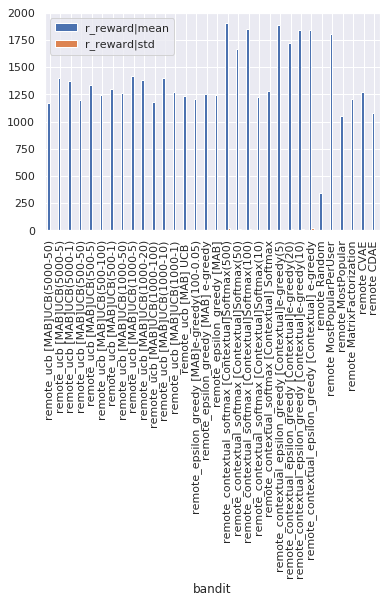

In [21]:
df_all[['r_reward|mean', 'r_reward|std']].plot(kind='bar')

In [22]:
df_all.to_csv("output/tmp/stats.csv", float_format='%.2f')

In [23]:
df_all

,r_mean|mean,r_mean|std,r_reward|mean,r_reward|std,r_reward|count,model|first
bandit,,,,,,
remote_ucb [MAB]UCB(5000-50),0.101979,NaN,1170.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______1678f503be
remote_ucb [MAB]UCB(5000-5),0.121764,NaN,1397.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______f99330d50d
remote_ucb [MAB]UCB(5000-1),0.119498,NaN,1371.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______6661578c77
remote_ucb [MAB]UCB(500-50),0.104506,NaN,1199.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______dc65eb5f8d
remote_ucb [MAB]UCB(500-5),0.116273,NaN,1334.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______962f3e5fff
remote_ucb [MAB]UCB(500-100),0.108603,NaN,1246.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______7b8ff911d0
remote_ucb [MAB]UCB(500-1),0.113571,NaN,1303.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______ffd53e3cef
remote_ucb [MAB]UCB(1000-50),0.109736,NaN,1259.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______9ec9c7ceb5
remote_ucb [MAB]UCB(1000-5),0.123682,NaN,1419.0,NaN,1,output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_ucb___endpoints______995e2b5291


## Plot Test

In [24]:
df_models = list_bandits.set_index('name')[['model_list']]


legend = {'remoteCDAE': "CDAE", 
         'remoteCVAE': "CVAE",  
         'remoteMatrixFactorization': 'Matrix Factorization',
         'remoteMostPopular': 'Most Popular',
         'remoteMostPopularPerUser': 'Most Popular per User',
         'remoteRandom': 'Random',
         'remote_contextual_epsilon_greedy[Contextual]e-greedy': 'Contextual e-greedy',
         'remote_contextual_softmax[Contextual]Softmax': 'Contextual Softmax',
         'remote_epsilon_greedy[MAB]e-greedy': 'e-greedy', 
         'remote_ucb[MAB]UCB': 'UCB',
         'remote_contextual_softmax[Contextual]Softmax(10)':'Meta-Bandit Softmax (c=10)', 
         'remote_contextual_softmax[Contextual]Softmax(50)':'Meta-Bandit Softmax (c=50)',
         'remote_contextual_softmax[Contextual]Softmax(100)':'Meta-Bandit Softmax (c=100)',
         'remote_contextual_softmax[Contextual]Softmax(500)':'Meta-Bandit Softmax (c=500)',
         'remote_contextual_epsilon_greedy[Contextual]e-greedy(5)': 'Meta-Bandit e-greedy (e=0.05)',
         'remote_contextual_epsilon_greedy[Contextual]e-greedy(10)': 'Meta-Bandit e-greedy (e=0.1)',
         'remote_contextual_epsilon_greedy[Contextual]e-greedy(20)': 'Meta-Bandit e-greedy (e=0.2)',
         "remote_ucb[MAB]UCB(1000-1)": "Meta-Bandit UCB (c=1)",                               
         "remote_ucb[MAB]UCB(1000-5)": "Meta-Bandit UCB (c=5)",                      
         "remote_ucb[MAB]UCB(1000-10)": "Meta-Bandit UCB (c=10)",  
         "remote_ucb[MAB]UCB(1000-20)": "Meta-Bandit UCB (c=20)",                            
         "remote_ucb[MAB]UCB(1000-50)": "Meta-Bandit UCB (c=50)"       
        }

df_models.index = df_models.index.map(legend)
#df_models['model'] = df_models['bandit']
df_models.head(10)

,model_list
name,
CDAE,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______68e9460cc6]
CVAE,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d73aadc920]
Matrix Factorization,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______d2667d3c0b]
Most Popular,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______5dab9c3b0a]
Most Popular per User,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______1c7fdcea43]
Random,[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote___endpoints______44e07863e7]
Contextual e-greedy,"[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______c87eb8d2e4, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______c8e04246ca, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______4e6c98d63b, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______fcb92f2a09, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______08b565350d, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______28dd73806b, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______659dab8004, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______e7f48c2e17, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______7d9bc9b8c0, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______09a2bee226]"
Meta-Bandit e-greedy (e=0.1),"[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______a76a90a61e, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______4ff016af76, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______0feb7c0bb3, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______7fb6ccf0ff, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______358f86af78, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______3ef836e8d0, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______d057f8a431, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______1da16d1496, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______1b789671da, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______cb93edb8ec]"
Meta-Bandit e-greedy (e=0.2),"[output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______082858ed2f, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______bfe9016dc1, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______4d0972524c, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______b57e7f1758, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___endpoints______83b19d6630, output/interaction/EnsambleMABInteraction/results/EnsambleMABInteraction____remote_contextua___

In [25]:
bandits           = legend.values()

sample_size       = 15000
window_size       = 1000 
bandits

dict_values(['CDAE', 'CVAE', 'Matrix Factorization', 'Most Popular', 'Most Popular per User', 'Random', 'Contextual e-greedy', 'Contextual Softmax', 'e-greedy', 'UCB', 'Meta-Bandit Softmax (c=10)', 'Meta-Bandit Softmax (c=50)', 'Meta-Bandit Softmax (c=100)', 'Meta-Bandit Softmax (c=500)', 'Meta-Bandit e-greedy (e=0.05)', 'Meta-Bandit e-greedy (e=0.1)', 'Meta-Bandit e-greedy (e=0.2)', 'Meta-Bandit UCB (c=1)', 'Meta-Bandit UCB (c=5)', 'Meta-Bandit UCB (c=10)', 'Meta-Bandit UCB (c=20)', 'Meta-Bandit UCB (c=50)'])

In [26]:
# df_metrics        = load_all_iteraction_metrics(input_iteraction, sample_size)

# df_metrics.groupby(['iteraction', 'idx']).sum().fillna(0).groupby(level=0).rolling(window = window_size, min_periods=1).mean().reset_index(drop=True)

In [27]:
def load_dataset(df_models, bandits, sample_size):
    data = []
    for bandit in bandits:
        input_iteraction  = [p.split("/")[-1] for p in df_models.loc[bandit].model_list]
        df_metrics        = load_all_iteraction_metrics(input_iteraction, sample_size)
        #params            = load_iteractions_params2(input_iteraction)
        
        
        df        = load_all_iteraction_metrics(input_iteraction, sample_size)
        df['_idx'] = 1
        df_metrics                    = df.groupby(['iteraction', 'idx']).sum().fillna(0).groupby(level=0).cumsum().reset_index()
        df_metrics['mean_reward']     = (df_metrics.reward/df_metrics._idx).fillna(0)
        df_metrics['mean_reward_win'] = df.groupby(['iteraction', 'idx']).sum().fillna(0).groupby(level=0).rolling(window = window_size, min_periods=1).mean().reset_index(drop=True).reward

        df_metrics['bandit']      = bandit
        df_metrics['Model']       = bandit

        data.append(df_metrics)
    return pd.concat(data, ignore_index=True)

    
df_group = load_dataset(df_models, bandits, sample_size)
df_group.tail()

,iteraction,idx,user,item,reward,index_env,_idx,mean_reward,mean_reward_win,bandit,Model
1388228,EnsambleMABInteraction____remote_ucb___endpoints______9ec9c7ceb5,11468,2730766679,47538163,1259.0,65763246,11469,0.109774,0.103,Meta-Bandit UCB (c=50),Meta-Bandit UCB (c=50)
1388229,EnsambleMABInteraction____remote_ucb___endpoints______9ec9c7ceb5,11469,2731015101,47543090,1259.0,65774715,11470,0.109765,0.102,Meta-Bandit UCB (c=50),Meta-Bandit UCB (c=50)
1388230,EnsambleMABInteraction____remote_ucb___endpoints______9ec9c7ceb5,11470,2731278512,47548017,1259.0,65786185,11471,0.109755,0.101,Meta-Bandit UCB (c=50),Meta-Bandit UCB (c=50)
1388231,EnsambleMABInteraction____remote_ucb___endpoints______9ec9c7ceb5,11471,2731406796,47554475,1259.0,65797656,11472,0.109745,0.100,Meta-Bandit UCB (c=50),Meta-Bandit UCB (c=50)
1388232,EnsambleMABInteraction____remote_ucb___endpoints______9ec9c7ceb5,11472,2731788585,47561397,1259.0,65809128,11473,0.109736,0.099,Meta-Bandit UCB (c=50),Meta-Bandit UCB (c=50)


In [28]:
#df_group['idx'].isin(df_group.idx.sample(200, random_state=41))

### Cumulative Reward

In [153]:
def plot_cum_reward(df, column='mean_reward', hue='bandit', legend=False, legend_extern=False, 
                    ylim=1, hue_order=None, y_axes=True, markersize=6):
    name = models[0].replace(" ", "_")
    #df = df[df.idx > 10]
    steps = int(df_group.idx.max()/25)
    idx   = [steps*i for i in range(steps)]    
    df = df[df.idx.isin(idx)]
    #df = df.sample(200, random_state=41)
    
    plt.figure()
    sns.set(style="darkgrid")
    sns.set(style="whitegrid", rc={"lines.scale_dashes": True, "lines.linewidth": 2.0})

    # Plot the responses for different events and regions
    ax =  sns.lineplot(x="idx", y=column, markers=markers, dashes=False, palette=palette,
                       style=hue, hue=hue, hue_order=hue_order, legend=legend,  data=df, markersize=markersize)
    ax.set_ylim(0,ylim)
    ax.set_yticks([0,500,1000,1500,2000])

    #ax.set(xlabel='Interactions', ylabel='Cumulative Mean Reward',fontsize=20)
    ax.tick_params(labelsize=11)
    ax.set_xlabel('Interactions',fontsize=15);
    if y_axes:
        ax.set_ylabel('Cumulative Reward',fontsize=15);
    else:
        ax.set_ylabel("")
    # Put the legend out of the figure
    if legend and legend_extern:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)
    
    ax.grid(False)

    plt.savefig("output/tmp/plot_cum_reward_{}_{}_{}.pdf".format(name,legend,legend_extern) ,dpi=300, bbox_inches="tight")
    plt.show()

#### Cumulate Reward hyperparams

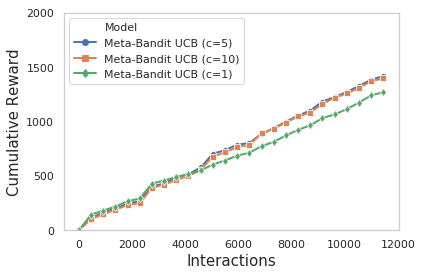

In [154]:
models = ["Meta-Bandit UCB (c=5)", "Meta-Bandit UCB (c=10)", "Meta-Bandit UCB (c=1)"]
palette = dict(zip(models, sns.color_palette("deep", 7)))
markers = dict(zip(models, ["o","s", "d", "P", "X",  "^", "v"]))

df_group = load_dataset(df_models, models, sample_size)
plot_cum_reward(df_group, column='reward', legend='full', hue='Model', hue_order=models, ylim=2000, y_axes=True)

In [155]:
models  = ['Meta-Bandit Softmax (c=500)', 'Meta-Bandit Softmax (c=100)',  
           'Meta-Bandit Softmax (c=50)', 'Meta-Bandit Softmax (c=10)']
palette = dict(zip(models, sns.color_palette("deep", 7)))
markers = dict(zip(models, ["o","s", "d", "P", "X",  "^", "v"]))


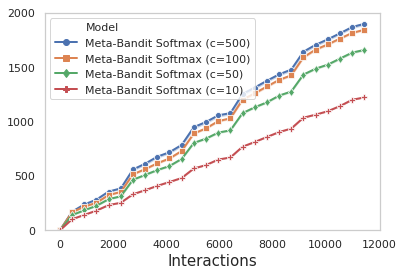

In [156]:
df_group = load_dataset(df_models, models, sample_size)
#df_group = df_group.groupby(['Model', 'idx']).median().reset_index()

plot_cum_reward(df_group, column='reward', legend='full', hue='Model', hue_order=models, ylim=2000, y_axes=False)

In [157]:
models  = ['Meta-Bandit e-greedy (e=0.05)', 'Meta-Bandit e-greedy (e=0.1)', 'Meta-Bandit e-greedy (e=0.2)']
palette = dict(zip(models, sns.color_palette("deep", 7)))
markers = dict(zip(models, ["o","s", "d", "P", "X",  "^", "v"]))


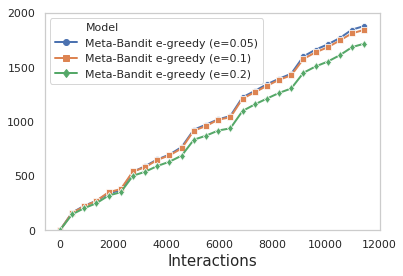

In [158]:
df_group = load_dataset(df_models, models, sample_size)
df_group = df_group.groupby(['Model', 'idx']).median().reset_index()

plot_cum_reward(df_group, column='reward', legend='full', hue='Model', hue_order=models, ylim=2000, y_axes=False)

#### Cumulate Reward Best Models

In [159]:
legend.values()

dict_values(['CDAE', 'CVAE', 'Matrix Factorization', 'Most Popular', 'Most Popular per User', 'Random', 'Contextual e-greedy', 'Contextual Softmax', 'e-greedy', 'UCB', 'Meta-Bandit Softmax (c=10)', 'Meta-Bandit Softmax (c=50)', 'Meta-Bandit Softmax (c=100)', 'Meta-Bandit Softmax (c=500)', 'Meta-Bandit e-greedy (e=0.05)', 'Meta-Bandit e-greedy (e=0.1)', 'Meta-Bandit e-greedy (e=0.2)', 'Meta-Bandit UCB (c=1)', 'Meta-Bandit UCB (c=5)', 'Meta-Bandit UCB (c=10)', 'Meta-Bandit UCB (c=20)', 'Meta-Bandit UCB (c=50)'])

In [160]:
models  = ['Meta-Bandit e-greedy (e=0.05)', 'Meta-Bandit Softmax (c=500)',
           'Meta-Bandit UCB (c=10)', 'CVAE', 'CDAE', 
           'Matrix Factorization', 'Most Popular', 'Random']
palette = dict(zip(models, sns.color_palette("deep", 8)))

markers = dict(zip(models, ["o","s", "d", "P", "X",  "^", "v", "."]))


<Figure size 7200x36000 with 0 Axes>

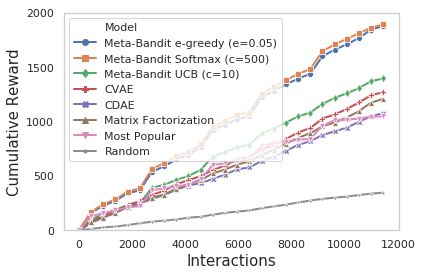

In [161]:

df_group = load_dataset(df_models, models, sample_size)
df_group = df_group.groupby(['Model', 'idx']).median().reset_index()

plt.figure(figsize=(100, 500))
plot_cum_reward(df_group, column='reward', legend='full', hue='Model', hue_order=models, ylim=2000)

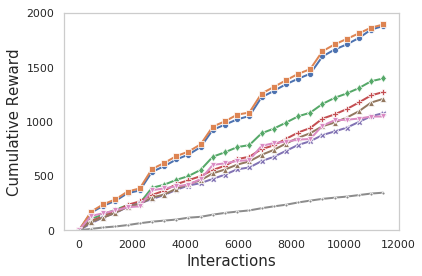

In [162]:
plot_cum_reward(df_group, column='reward', legend=False, hue='Model', 
                hue_order=models, ylim=2000, legend_extern=False)

### Cumulative Mean Reward

In [175]:
from matplotlib.colors import LogNorm
def plot_cum_mean_reward(df, column='mean_reward', hue='bandit', hue_order=None, 
                         legend=False, legend_extern=False, markersize=5,
                         ylim=1, title="plot_cum_mean_reward", palette=palette, figsize=None):
    #df = df.sample(200, random_state=41)

    steps = int(df_group.idx.max()/35)
    idx   = [steps*i for i in range(steps)]    
    df = df[df.idx.isin(idx)]
    
    plt.figure(figsize=figsize)
    sns.set(style="whitegrid", rc={"lines.scale_dashes": True, "lines.linewidth": 2.0})

    # Plot the responses for different events and regions
    ax =  sns.lineplot(x="idx", y=column, markers=markers, dashes=False, palette=palette,
                       style=hue, hue=hue, hue_order=hue_order, legend=legend, data=df, markersize=markersize)
    ax.set_ylim(0,ylim)
    #ax.set(xlabel='Interactions', ylabel='Cumulative Mean Reward',fontsize=20)
    ax.tick_params(labelsize=11)
    ax.set_yticks([0,0.1,0.2,0.3,0.4])
    ax.set_xlabel('Interactions',fontsize=15);
    ax.set_ylabel('Cumulative Mean Reward',fontsize=15);
    # Put the legend out of the figure
    if legend and legend_extern:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15)
    
    ax.grid(False)
    
    #ax.set_xticklabels(["1,", "2", "3", "4", "5", "6", "7"])
    
    plt.savefig("output/tmp/{}_{}_{}.pdf".format(title, legend, legend_extern),dpi=300, bbox_inches="tight")
    plt.show()


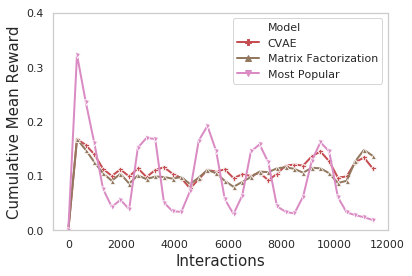

In [176]:
models  = ['CVAE', 'Matrix Factorization', 'Most Popular']
df_group = load_dataset(df_models, models, sample_size)
df_group = df_group.groupby(['Model', 'idx']).mean().reset_index()
plot_cum_mean_reward(df_group, column='mean_reward_win', title="plot_cum_mean_reward_models",
                     legend='full',hue_order=models, hue='Model', ylim=0.4)

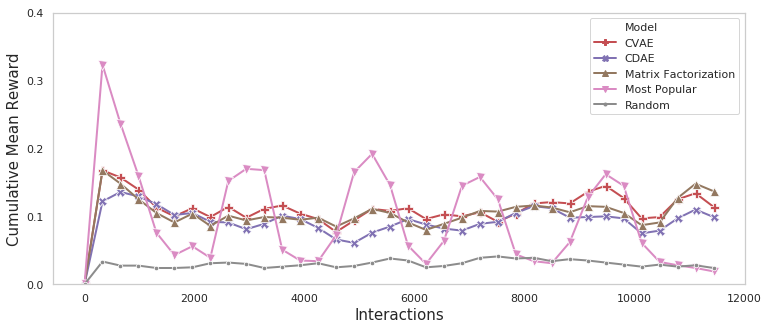

In [183]:
models  = ['CVAE', 'CDAE', 'Matrix Factorization', 'Most Popular', 'Random']
df_group = load_dataset(df_models, models, sample_size)
df_group = df_group.groupby(['Model', 'idx']).mean().reset_index()


plot_cum_mean_reward(df_group, column='mean_reward_win', title="plot_cum_mean_reward_models",markersize=9,
                     legend='full',hue_order=models, hue='Model', ylim=0.4, figsize=(12.4, 5))

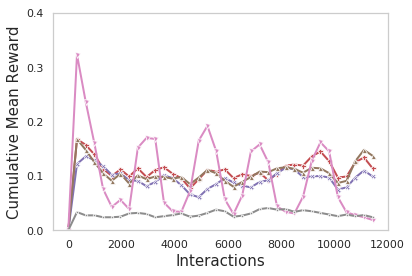

In [166]:
models  = ['CVAE', 'CDAE', 'Matrix Factorization', 'Most Popular', 'Random']
df_group = load_dataset(df_models, models, sample_size)
df_group = df_group.groupby(['Model', 'idx']).mean().reset_index()
plot_cum_mean_reward(df_group, column='mean_reward_win', title="plot_cum_mean_reward_models_note_legend",
                     legend=False,hue_order=models, hue='Model', ylim=0.4)

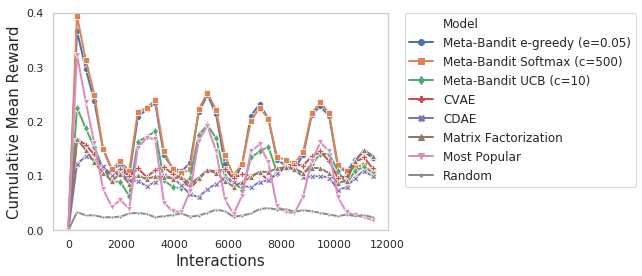

In [113]:
models  = ['Meta-Bandit e-greedy (e=0.05)', 'Meta-Bandit Softmax (c=500)', 'Meta-Bandit UCB (c=10)', 
           'CVAE', 'CDAE', 'Matrix Factorization', 'Most Popular', 'Random']
df_group = load_dataset(df_models, models, sample_size)
df_group = df_group.groupby(['Model', 'idx']).mean().reset_index()
plot_cum_mean_reward(df_group, column='mean_reward_win', title="plot_cum_mean_reward_all_models_slim",
                     legend='full',hue_order=models, hue='Model', ylim=0.4, legend_extern=True)

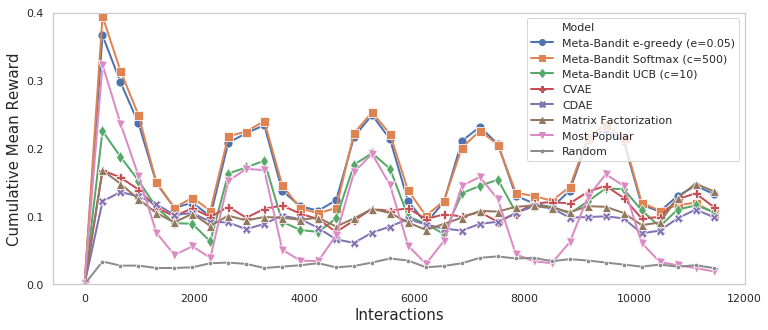

In [177]:
models  = ['Meta-Bandit e-greedy (e=0.05)', 'Meta-Bandit Softmax (c=500)', 'Meta-Bandit UCB (c=10)', 
           'CVAE', 'CDAE', 'Matrix Factorization', 'Most Popular', 'Random']
df_group = load_dataset(df_models, models, sample_size)
df_group = df_group.groupby(['Model', 'idx']).mean().reset_index()

plot_cum_mean_reward(df_group, column='mean_reward_win', title="plot_cum_mean_reward_all_models",markersize=9,
                     legend='full',hue_order=models, hue='Model', ylim=0.4, figsize=(12.4, 5))

In [180]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

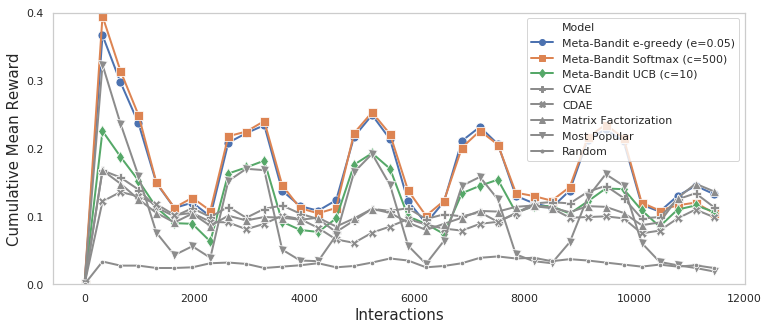

In [181]:
palette2 = {'Meta-Bandit e-greedy (e=0.05)': (0.2980392156862745,
                                          0.4470588235294118,
                                          0.6901960784313725),
             'Meta-Bandit Softmax (c=500)': (0.8666666666666667,
                                          0.5176470588235295,
                                          0.3215686274509804),
             'Meta-Bandit UCB (c=10)': (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),            
             'CVAE': (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
             'CDAE': (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
             'Matrix Factorization': (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
             'Most Popular': (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
             'Random': (0.5490196078431373, 0.5490196078431373, 0.5490196078431373)}

models  = ['Meta-Bandit e-greedy (e=0.05)', 'Meta-Bandit Softmax (c=500)', 'Meta-Bandit UCB (c=10)', 
           'CVAE', 'CDAE', 'Matrix Factorization', 'Most Popular', 'Random']
df_group = load_dataset(df_models, models, sample_size)
df_group = df_group.groupby(['Model', 'idx']).mean().reset_index()


plot_cum_mean_reward(df_group, column='mean_reward_win', title="plot_cum_mean_reward_all_models_fade",markersize=9,
                     legend='full',hue_order=models, hue='Model', ylim=0.4, figsize=(12.4, 5), palette=palette2)

In [182]:
palette2 = {'Meta-Bandit e-greedy (e=0.05)': (0.2980392156862745,
                                          0.4470588235294118,
                                          0.6901960784313725),
             'Meta-Bandit Softmax (c=500)': (0.8666666666666667,
                                          0.5176470588235295,
                                          0.3215686274509804),
             'CVAE': (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
             'CDAE': (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
             'Matrix Factorization': (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
             'Most Popular': (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
             'Random': (0.5490196078431373, 0.5490196078431373, 0.5490196078431373)}

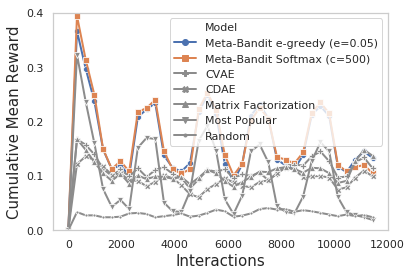

In [68]:
models  = ['Meta-Bandit e-greedy (e=0.05)', 'Meta-Bandit Softmax (c=500)', 
           'CVAE', 'CDAE', 'Matrix Factorization', 'Most Popular', 'Random']
df_group = load_dataset(df_models, models, sample_size)
df_group = df_group.groupby(['Model', 'idx']).mean().reset_index()
plot_cum_mean_reward(df_group, column='mean_reward_win', title="plot_cum_mean_reward_all_models_fade",
                     legend='full',hue_order=models, hue='Model', ylim=0.4, palette=palette2)

## Explorer Bandit 

In [36]:
import pandas as pd
import pickle
import re
import sys
import numpy as np
import streamlit as st
import pandas as pd
import numpy as np
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
import os
import seaborn as sns
import plotly.express as px

In [70]:
bandits  = ['Meta-Bandit e-greedy (e=0.05)', 'Meta-Bandit Softmax (c=500)', 'Meta-Bandit UCB (c=10)']
df_group = load_dataset(df_models, bandits, sample_size)
df_group.tail()

df_plot = df_group.sort_values('reward').groupby('bandit').last().reset_index()
df_plot

,bandit,iteraction,idx,user,item,reward,index_env,_idx,mean_reward,mean_reward_win,Model
0,Meta-Bandit Softmax (c=500),EnsambleMABInteraction____remote_contextua___endpoints______bb03e06dff,11472,2731788585,41799186,1939.0,65809128,11473,0.169005,0.105,Meta-Bandit Softmax (c=500)
1,Meta-Bandit UCB (c=10),EnsambleMABInteraction____remote_ucb___endpoints______506ed24005,11471,2731406796,47534105,1398.0,65797656,11472,0.121862,0.101,Meta-Bandit UCB (c=10)
2,Meta-Bandit e-greedy (e=0.05),EnsambleMABInteraction____remote_contextua___endpoints______80ea313ae2,11472,2731788585,42125716,1888.0,65809128,11473,0.164560,0.125,Meta-Bandit e-greedy (e=0.05)


In [71]:
import gc
gc.collect()

33635

In [73]:
import pickle
def load_bandit(iteraction):
    path = '/media/workspace/DeepFood/deep-reco-gym/output/interaction/EnsambleMABInteraction/results/{}/'.format(iteraction)
    bandit = pickle.load(open(path+"/"+"bandit.pkl", "rb"))
    return bandit
bandit = load_bandit(df_plot.iloc[0].iteraction)

In [74]:
def get_arms(bandit):
    arms    = np.unique(bandit._arms_selected)
    arms_rewards = bandit._arms_selected
    rounds  = len(bandit._arms_selected)
    count_per_arms = {}

    for a in arms:
        count_per_arms[a] = np.zeros(rounds)


    for r in range(rounds):
        count_per_arms[arms_rewards[r]][r] = 1

    return count_per_arms

In [75]:
count_per_arms = get_arms(bandit)
count_per_arms

{0: array([0., 0., 0., ..., 1., 0., 1.]),
 1: array([0., 0., 0., ..., 0., 0., 0.]),
 2: array([1., 1., 0., ..., 0., 1., 0.]),
 3: array([0., 0., 1., ..., 0., 0., 0.])}

In [76]:
def stack_values(count_per_arms, window = 1000):

    values = count_per_arms[0]

    arm1 = pd.Series(count_per_arms[0]).rolling(window = window, min_periods=1).mean()
    arm2 = pd.Series(count_per_arms[1]).rolling(window = window, min_periods=1).mean()
    arm3 = pd.Series(count_per_arms[2]).rolling(window = window, min_periods=1).mean()
    arm4 = pd.Series(count_per_arms[3]).rolling(window = window, min_periods=1).mean()

    data = pd.DataFrame({'arm1': arm1, 'arm2': arm2, 'arm3': arm3, 'arm4': arm4})
    return data

data = stack_values(count_per_arms, window = 1000)

In [77]:
bandit._endpoints

('http://localhost:5001/rank',
 'http://localhost:5003/rank',
 'http://localhost:5004/rank',
 'http://localhost:5005/rank')

In [78]:
palette

{'Meta-Bandit e-greedy (e=0.05)': (0.2980392156862745,
  0.4470588235294118,
  0.6901960784313725),
 'Meta-Bandit Softmax (c=500)': (0.8666666666666667,
  0.5176470588235295,
  0.3215686274509804),
 'Meta-Bandit UCB (c=10)': (0.3333333333333333,
  0.6588235294117647,
  0.40784313725490196),
 'CVAE': (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 'CDAE': (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 'Matrix Factorization': (0.5764705882352941,
  0.47058823529411764,
  0.3764705882352941),
 'Most Popular': (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 'Random': (0.5490196078431373, 0.5490196078431373, 0.5490196078431373)}

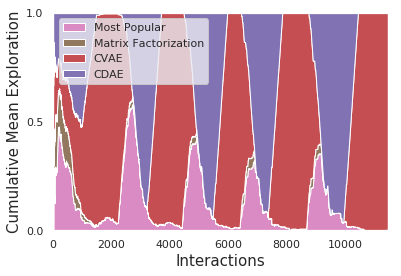

In [89]:
def plot_exploration(data, title = "exploration_fig.pdf", 
                     labels=['Most Popular', 'Matrix Factorization','CVAE', 'CDAE'], y_axes=True, legend=True):

    colors=[palette[l] for l in labels]
    #models  = ['CVAE', 'CDAE', 'Matrix Factorization', 'Most Popular', 'Random']
    plt.figure()

    sns.set(style="darkgrid")
    plt.xlabel('Interactions', fontsize=15)
    

    if y_axes:
        plt.ylabel('Cumulative Mean Exploration', fontsize=15)
    else:
        plt.ylabel('', fontsize=15)
        
    # We need to transform the data from raw data to percentage (fraction)
    data_perc = data.divide(data.sum(axis=1), axis=0)

    # Make the plot
    plt.stackplot(range(len(data)),  data_perc["arm1"],  data_perc["arm2"],  
                  data_perc["arm3"],  data_perc["arm4"], labels=labels, colors=colors)
    if legend:
        plt.legend(loc='upper left')
    plt.margins(0,0)
    plt.yticks([0,0.5,1])

    plt.tick_params(labelsize=11)

    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)
    plt.savefig("output/tmp/{}.pdf".format(title),dpi=300, bbox_inches="tight")
    plt.show()
    
plot_exploration(data)

### Plot

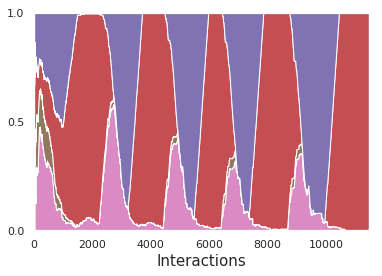

In [121]:
model  = df_plot.iloc[0]
bandit = load_bandit(model.iteraction)
count_per_arms = get_arms(bandit)
data = stack_values(count_per_arms, window = 500)
plot_exploration(data, legend=False, y_axes=False, title = "exploration_fig_{}.pdf".format(model.bandit.replace(" ", "_")))

In [117]:
model

bandit             Meta-Bandit Softmax (c=500)                                           
iteraction         EnsambleMABInteraction____remote_contextua___endpoints______bb03e06dff
idx                11472                                                                 
user               2731788585                                                            
item               41799186                                                              
reward             1939                                                                  
index_env          65809128                                                              
_idx               11473                                                                 
mean_reward        0.169005                                                              
mean_reward_win    0.105                                                                 
Model              Meta-Bandit Softmax (c=500)                                           
Name: 0, d

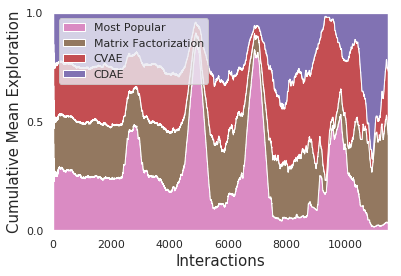

In [118]:
model  = df_plot.iloc[1]

bandit = load_bandit(model.iteraction)
count_per_arms = get_arms(bandit)
data = stack_values(count_per_arms, window = 500)
plot_exploration(data, title = "exploration_fig_{}.pdf".format(model.bandit.replace(" ", "_")))

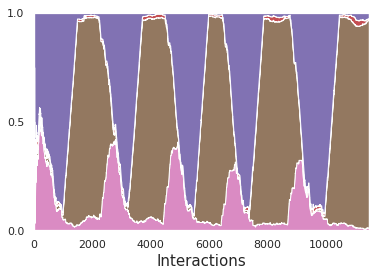

In [122]:
model  = df_plot.iloc[2]

bandit = load_bandit(model.iteraction)
count_per_arms = get_arms(bandit)
data = stack_values(count_per_arms, window = 500)
plot_exploration(data, legend=False, y_axes=False, title = "exploration_fig_{}.pdf".format(model.bandit.replace(" ", "_")))

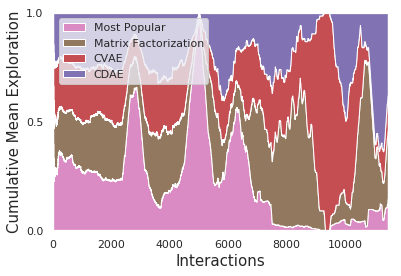

In [120]:
p = 'EnsambleMABInteraction____remote_ucb___endpoints______995e2b5291'


bandit = load_bandit(p)
count_per_arms = get_arms(bandit)
data = stack_values(count_per_arms, window = 500)
plot_exploration(data, title = "exploration_fig_egreedy.pdf", )

## Performance per feature

In [18]:
df_train = pd.read_parquet('output/new_ifood/new_ifood_dataset/train/')
df_train = df_train.groupby('account_idx').agg({'buys': 'count'}).reset_index()
df_train

,account_idx,buys
0,0,1
1,1,9
2,2,1
3,3,1
4,4,12
...,...,...
464111,476841,3
464112,476842,1
464113,476843,41
464114,476844,1


In [19]:
#df_val = pd.read_parquet('output/new_ifood/new_ifood_dataset/validation/')[['account_id', 'merchant_id']]
#df_val = df_train.groupby('account_idx').agg({'buys': 'count'}).reset_index()
#df_val[[]]

In [ ]:
iteraction = 'EnsambleMABInteraction____remote___endpoints______44e07863e7'
path = '/media/workspace/DeepFood/deep-reco-gym/output/interaction/EnsambleMABInteraction/results/{}/'.format(iteraction)

df_sim = pd.read_csv(path+"/sim-datalog.csv")
df_sim.head()

In [ ]:
df_all = pd.read_csv(path+"/gt-datalog.csv")[['account_idx', 'weekday breakfast', 'weekday dawn', 'weekday lunch', 'weekday snack','weekday dinner', 'weekend dawn', 'weekend lunch', 'weekend dinner']]
df_all.head(2)

df_all = df_all.merge(df_train, on=['account_idx'], how='left').fillna(0)
df_all = df_all.join(df_sim['reward'])

df_all

In [ ]:
df_all.head(5)

In [ ]:
#df_all['shift']

In [ ]:
df_shift = df_all[['weekday breakfast', 'weekday dawn', 'weekday lunch', 'weekday snack','weekday dinner', 'weekend dawn', 'weekend lunch', 'weekend dinner']]
df_all['shift_idx'] = df_shift.apply(lambda row: np.max(np.array(row.values) * np.array([0,1,2,3,4,5,6,7])),axis=1)
df_all['buys_bin']  = pd.cut(df_all['buys'], 100)

In [ ]:
df_all.head(10)

In [ ]:
df_all['buys'].hist()

In [ ]:
for i, c in enumerate(df_all['buys_bin'].cat.categories):
    print(c)

In [ ]:
all_data = []
c    = df_all['buys_bin'].cat.categories[0]
data = df_all[df_all.buys_bin == c]

all_data.append(data)
for c in df_all['buys_bin'].cat.categories[1:]:
    data = pd.concat([data, df_all[df_all.buys_bin == c]])
    data['buys_bin'] = c
    all_data.append(data)
    
df = pd.concat(all_data)
df.shape    

In [ ]:
df_result = df.groupby(['buys_bin', 'shift_idx']).agg({'reward': 'mean'}).fillna(0).reset_index()
df_result

In [ ]:
# Load the example flights dataset and convert to long-form
pvt = df_result.pivot("buys_bin", "shift_idx", "reward").sort_index(ascending=False)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(pvt, annot=True, fmt=".2f", linewidths=.5, ax=ax)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

rcstyle = {'axes.linewidth': 1.0, 'axes.edgecolor': 'black','ytick.minor.size': 5.0}
sns.set(font_scale=2.0)
sns.set_style('ticks', rcstyle)

plt.figure(figsize=(18, 10))
ax = sns.heatmap(pvt, cmap='magma_r')

plt.xticks(rotation=0);
plt.yticks(rotation=0);

# ax.set_ylabel('Time')
# ax.set_xticks(np.linspace(0, 200, 11))
# ax.set_xticklabels(np.linspace(0.0, 1.0, 11))

ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(True)

# ax.set_yticks([6*15*i + 78 for i in range(5)])
# ax.set_yticklabels([50*i for i in reversed(range(5))])
# ax.set_yticks([438 - 18*i for i in range(25)], minor=True)
#ax.invert_yaxis()

plt.xlabel('Axial reactor coordinate')
plt.ylabel('TOS [min]')
plt.tight_layout()

#plt.savefig('simulated_coke_profile.png')

In [ ]:
import numpy as np
import seaborn as sns
sns.set(style="ticks")

rs = np.random.RandomState(11)
x = rs.gamma(2, size=1000)
y = -.5 * x + rs.normal(size=1000)

sns.jointplot(x[:10], y[:10], kind="hex", color="#4CB391")

In [ ]:
x[:10]

In [ ]:
y[:10]

In [ ]:
l = {"0":"A", "1":"B", "2":"C", "3":"D", "4":"E", "5":"F", "6":"G", "7":"H"}

In [ ]:
df_f = df[df.reward >= 1][['buys', 'shift_idx']].reset_index().rename(columns={'buys': 'x', 'shift_idx': 'g'})
df_f['g'] = df_f['g'].apply(lambda x: l[str(x)])
df_f

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x  = rs.randn(500)
g  = np.tile(list("ABCDEFGHIJ"), 50)
df = df_f#pd.DataFrame(dict(x=x, g=g))
m  = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

# Apendce